In [58]:
#!pip install statsmodels
#!pip install pandas numpy matplotlib scikit-learn seaborn tensorflow
#!pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score)
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.utils import to_categorical


from statsmodels.tsa.stattools import adfuller

In [59]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
GPUs:  []


In [10]:
#Importing Data
data = pd.read_csv("data/ACLED2021-2024.csv")


data.drop(columns=['time_precision', 'assoc_actor_1', 'assoc_actor_2', 'iso', 'region', 'admin3', 'location', 
                  'latitude', 'longitude', 'geo_precision', 'source_scale', 'timestamp', 'tags', 'population_best', 'event_id_cnty'], 
          inplace=True)
print(data.shape)


data['event_date'] = pd.to_datetime(data['event_date'], errors = 'coerce') #changing to datetime
#data.set_index('event_date', inplace=True)
#data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

print(data.shape)
#data = data.dropna(subset=['event_date'])

(38130, 17)
(38130, 17)


38130 rows × 32 columns - Original Dataset Dimensions

In [11]:
# Dropping Dupes
initial_row_count = data.shape[0]
data = data.drop_duplicates()
final_row_count = data.shape[0]
print(f"Removed {initial_row_count - final_row_count} duplicates")
print(data.shape)

Removed 40 duplicates
(38090, 17)


In [12]:
#Reformatting / Cleaning

#Addressing NA values - Categorical, NUmerical and date
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2', 'source', 'notes']
categorical_columns = data[categorical_columns]


for column in categorical_columns:
    data[column] = data[column].fillna('Not specified')

numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction']

for column in numerical_columns:
    data[column] = data[column].fillna(data[column].median()) #using median to fill
    
print(data.isna().sum())
print(data.shape)
#data.loc[:, 'actor2'] = data['actor2'].fillna('Not specified')
#data.loc[:, 'civilian_targeting'] = data['civilian_targeting'].fillna('Not specified')

event_date            0
year                  0
disorder_type         0
event_type            0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
country               0
admin1                0
admin2                0
source                0
notes                 0
fatalities            0
dtype: int64
(38090, 17)


In [13]:
data

,event_date,year,disorder_type,event_type,sub_event_type,actor1,inter1,actor2,inter2,interaction,civilian_targeting,country,admin1,admin2,source,notes,fatalities
0,2024-04-19,2024,Political violence,Explosions/Remote violence,Shelling/artillery/missile attack,Hamas Movement,3,Not specified,0,30,Not specified,Israel,HaDarom,Ashqelon,N12; Times of Israel,"Interception: On 19 April 2024, Hamas militant...",0
1,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,Not specified,Israel,Haifa,Hadera,Ynet,"On 19 April 2024, thousands formed a human cha...",0
2,2024-04-19,2024,Demonstrations,Riots,Violent demonstration,Rioters (Israel),5,Rioters (Israel),5,55,Not specified,Israel,HaMerkaz,Ramla,Haaretz; Jerusalem Post; N12; Times of Israel;...,"On 19 April 2024, dozens of relatives of hosta...",0
3,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,Not specified,Israel,HaMerkaz,Rehovot,Ynet,"On 19 April 2024, thousands formed a human cha...",0
4,2024-04-19,2024,Political violence,Battles,Armed clash,Hezbollah,3,Military Forces of Israel (2022-),1,13,Not specified,Israel,HaZafon,Zefat,Jerusalem Post; Ma'ariv; Times of Israel,"On 19 April 2024, Hezbollah forces in Lebanon ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,Strategic developments,Strategic developments,Other,Military Forces of Israel (2009-2021),8,Civilians (Palestine),7,78,Not specified,Palestine,Gaza Strip,North Gaza,PLO Negotiations Affairs Department,"Other: On 20 April 2021, Israeli military forc...",0
38126,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Not specified,0,50,Not specified,Palestine,West Bank,Hebron,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers uprooted 20...",0
38127,2021-04-20,2021,Demonstrations,Protests,Peaceful protest,Protesters (Palestine),6,Not specified,0,60,Not specified,Palestine,Gaza Strip,Deir El Balah,Ma'an News Agency,"On 20 April 2021, a large protest organized by...",0
38128,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Civilians (Palestine),7,57,Civilian targeting,Palestine,West Bank,Ramallah and Al Bireh,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers from the Ba...",0


In [14]:
#Grouping Together Actor1 and 2
def consolidate_names(name):
    if 'Military Forces of Israel' in name:
        return 'Military Forces of Israel'
    elif 'Police Forces of Israel' in name:
        return 'Police Forces of Israel'
    elif 'Hamas Movement' in name:
        return 'Hamas Movement'
    elif 'Police Forces of Israel' in name or 'Government of Israel' in name:
        return 'Government and Police Forces of Israel'
    elif 'Police Forces of Palestine' in name or 'Government of Palestine' in name:
        return 'Government and Police Forces of Palestine'
    elif 'PIJ:' in name or 'Islamic Jihad' in name:
        return 'Palestinian Islamic Jihad'
    elif 'Hezbollah' in name:
        return 'Hezbollah'
    elif 'Al Aqsa' in name:
        return 'Al Aqsa Martyrs Brigade'
    elif 'Katibat' in name:
        return 'Katibat Groups (Palestine)'
    elif 'PFLP:' in name:
        return 'Popular Front for the Liberation of Palestine'
    elif 'DFLP:' in name:
        return 'Democratic Front for the Liberation of Palestine'
    elif 'Military Forces of Iran' in name:
        return 'Iranian Revolutionary Guard Corps'
    elif 'Islamic State' in name:
        return 'Islamic State'
#civilians
    elif 'Civilians' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  #Keeping isr and pal civilians
        else:
            return 'Civilians (International)'  # grouping others as int.
#armed groups
    elif 'Unidentified Armed Group' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Unidentified Armed Group (International)'
#military forces
    elif 'Military Forces of' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Military Forces of International Forces'
    elif 'Settlers' in name:
        return 'Settlers (Israel)'
    elif 'Protesters' in name or 'Rioters' in name:
        return name  # Retains specific categories due to their distinct contexts
    else:
        return name #'Other Groups' 

# Apply the consolidation function to both actor1 and actor2
data['actor1_grouped'] = data['actor1'].apply(consolidate_names)
data['actor2_grouped'] = data['actor2'].apply(consolidate_names)

In [15]:
#Grouping smaller entities
actor1_counts = data['actor1_grouped'].value_counts()
actor2_counts = data['actor2_grouped'].value_counts()

def consolidate_small_groups(name, counts): #Check if Isr or Pal if not 'name'
    if counts[name] < 10:
        if 'Israel' in name:
            return 'Other (Israel)'
        elif 'Palestine' in name:
            return 'Other (Palestine)'
        else:
            return'Other Group'
    else:
        # Return the name if the count is 10 or more
        return name

# Apply the consolidation function to both actor1_grouped and actor2_grouped
data['actor1_grouped'] = data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
data['actor2_grouped'] = data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))


# Print the new value counts to confirm re-categorization
#print(data['actor1_grouped'].value_counts())
#print(data['actor2_grouped'].value_counts())

data['actor1'] = data['actor1_grouped']
data['actor2'] = data['actor2_grouped']

data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)


In [16]:
print(data.isna().sum())


event_date            0
year                  0
disorder_type         0
event_type            0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
country               0
admin1                0
admin2                0
source                0
notes                 0
fatalities            0
dtype: int64


In [17]:
# Calculate the percentage of zero values per column
zero_counts = (data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(data)

# Display columns with high percentages of zeros
print("Percentage of zeros in each column:")
print(zero_percentage[zero_percentage > 0])  # Adjust the threshold as necessary


Percentage of zeros in each column:
inter2        27.274875
fatalities    91.047519
dtype: float64


In [18]:
#Creating Temporal Features for T-S

#Date related
data['year'] = data['event_date'].dt.year
data['month'] = data['event_date'].dt.month
data['day'] = data['event_date'].dt.day
data['day_of_week'] = data['event_date'].dt.day_name()
data['days_since_start'] = (data['event_date'] - data['event_date'].min()).dt.days

# time since last event of the same type
data['time_since_last_event'] = data.groupby('event_type')['event_date'].diff().dt.days
#data['time_since_last_event'] = data.groupby('event_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)


# time since last disorder of the same type
data['time_since_last_disorder'] = data.groupby('disorder_type')['event_date'].diff().dt.days
#data['time_since_last_disorder'] = data.groupby('disorder_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)
#print(data[['time_since_last_event', 'time_since_last_disorder']].head())


# rolling avg for fatalities
data['rolling_avg_fatalities_7d'] = data.groupby(
    'event_type')['fatalities'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


# cumulative counts of events and fatalities by specific features
data['cumulative_events'] = data.groupby(['event_type']).cumcount() + 1
data['cumulative_fatalities'] = data.groupby(['event_type'])['fatalities'].cumsum()

log_data = data.copy()


In [19]:
#Log transformations
log_columns = ['fatalities', 'cumulative_events', 'cumulative_fatalities', 'rolling_avg_fatalities_7d', 
               'time_since_last_event', 'time_since_last_disorder', 'days_since_start']
for col in log_columns:
    log_data['log_' + col] = np.log1p(log_data[col])

# Creating lagged features
for col in log_columns:
    log_col = 'log_' + col
    for lag in [1, 2, 3]:
        log_data[f'{log_col}_lag{lag}'] = log_data[log_col].shift(lag)

D:\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
log_data

,event_date,year,disorder_type,event_type,sub_event_type,actor1,inter1,actor2,inter2,interaction,...,log_rolling_avg_fatalities_7d_lag3,log_time_since_last_event_lag1,log_time_since_last_event_lag2,log_time_since_last_event_lag3,log_time_since_last_disorder_lag1,log_time_since_last_disorder_lag2,log_time_since_last_disorder_lag3,log_days_since_start_lag1,log_days_since_start_lag2,log_days_since_start_lag3
0,2024-04-19,2024,Political violence,Explosions/Remote violence,Shelling/artillery/missile attack,Hamas Movement,3,Not specified,0,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.999422,NaN,NaN
2,2024-04-19,2024,Demonstrations,Riots,Violent demonstration,Rioters (Israel),5,Rioters (Israel),5,55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.999422,6.999422,NaN
3,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,6.999422,6.999422,6.999422
4,2024-04-19,2024,Political violence,Battles,Armed clash,Hezbollah,3,Military Forces of Israel,1,13,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,6.999422,6.999422,6.999422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,Strategic developments,Strategic developments,Other,Military Forces of Israel,8,Civilians (Palestine),7,78,...,0.0,0.0,-inf,0.0,0.0,-inf,0.0,0.000000,0.000000,0.000000
38126,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Not specified,0,50,...,0.0,0.0,0.0,-inf,0.0,0.0,-inf,0.000000,0.000000,0.000000
38127,2021-04-20,2021,Demonstrations,Protests,Peaceful protest,Protesters (Palestine),6,Not specified,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
38128,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Civilians (Palestine),7,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [21]:
#print(log_data)
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])


event_date                              0
year                                    0
disorder_type                           0
event_type                              0
sub_event_type                          0
actor1                                  0
inter1                                  0
actor2                                  0
inter2                                  0
interaction                             0
civilian_targeting                      0
country                                 0
admin1                                  0
admin2                                  0
source                                  0
notes                                   0
fatalities                              0
month                                   0
day                                     0
day_of_week                             0
days_since_start                        0
time_since_last_event                   6
time_since_last_disorder                4
rolling_avg_fatalities_7d         

In [22]:
#Cleaning log data

#replacing infinities w NaN
log_data.replace([np.inf, -np.inf], np.nan, inplace=True)
#log_data.fillna(log_data.median(), inplace=True)

#median for numeric columns
numeric_medians = log_data.select_dtypes(include=[np.number]).median()
log_data.fillna(numeric_medians, inplace=True)


log_data['time_since_last_event'].fillna(method='ffill', inplace=True)
log_data['time_since_last_event'].fillna(method='bfill', inplace=True)

lag_cols = [col for col in log_data.columns if ('log_time_since_last_event' in col or 'lag' in col) and 
            np.issubdtype(log_data[col].dtype, np.number)]

#for col in lag_cols:
    # method can be ffill, bfill
    #log_data[col] = log_data[col].interpolate(method='bfill')

C:\Users\aryaa\AppData\Local\Temp\ipykernel_23052\163424566.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  log_data['time_since_last_event'].fillna(method='ffill', inplace=True)
C:\Users\aryaa\AppData\Local\Temp\ipykernel_23052\163424566.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_data['time_since_last_event'].fillna(method='ffill', inplace=True)
C:\Users\aryaa\AppData\Local\Temp\ipykernel_23052\163424566.py:13: FutureWa

In [23]:
print(log_data.shape)
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])

(38090, 54)
event_date                            0
year                                  0
disorder_type                         0
event_type                            0
sub_event_type                        0
actor1                                0
inter1                                0
actor2                                0
inter2                                0
interaction                           0
civilian_targeting                    0
country                               0
admin1                                0
admin2                                0
source                                0
notes                                 0
fatalities                            0
month                                 0
day                                   0
day_of_week                           0
days_since_start                      0
time_since_last_event                 0
time_since_last_disorder              0
rolling_avg_fatalities_7d             0
cumulative_events           

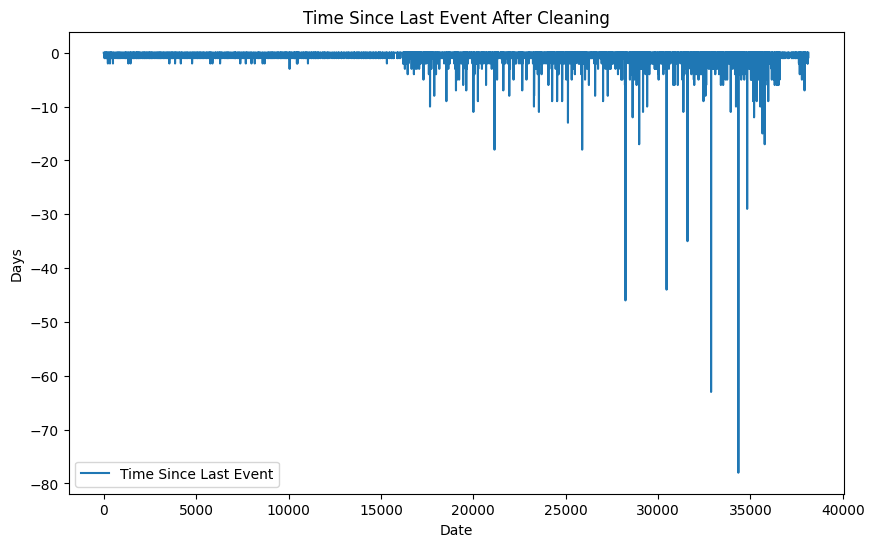

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(log_data['time_since_last_event'], label='Time Since Last Event')
plt.title('Time Since Last Event After Cleaning')
plt.xlabel('Date')
plt.ylabel('Days')
plt.legend()
plt.show()


In [25]:
#Encoding

#One-Hot for Categoricals
categorical_cols = ['disorder_type', 'event_type', 'actor1', 'actor2', 'civilian_targeting',
                    'country', 'admin1', 'admin2', 'day_of_week']
log_data_encoded = pd.get_dummies(log_data, columns=categorical_cols)
log_data_encoded

#Label Encoder
label_encoders = {}

for col in ['inter1', 'inter2', 'interaction', 'sub_event_type']:
    le = LabelEncoder()
    log_data_encoded[col] = le.fit_transform(log_data_encoded[col])
    label_encoders[col] = le  # storing the encoder
#print(log_data_encoded.isna().sum())
log_data_encoded.to_csv('data/log_data_encoded.csv', index=False)

In [26]:
log_data_encoded

,event_date,year,sub_event_type,inter1,inter2,interaction,source,notes,fatalities,month,...,admin2_Tulkarm,admin2_Yizreel,admin2_Zefat,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,2024-04-19,2024,18,2,0,9,N12; Times of Israel,"Interception: On 19 April 2024, Hamas militant...",0,4,...,False,False,False,True,False,False,False,False,False,False
1,2024-04-19,2024,15,5,0,21,Ynet,"On 19 April 2024, thousands formed a human cha...",0,4,...,False,False,False,True,False,False,False,False,False,False
2,2024-04-19,2024,19,4,4,17,Haaretz; Jerusalem Post; N12; Times of Israel;...,"On 19 April 2024, dozens of relatives of hosta...",0,4,...,False,False,False,True,False,False,False,False,False,False
3,2024-04-19,2024,15,5,0,21,Ynet,"On 19 April 2024, thousands formed a human cha...",0,4,...,False,False,False,True,False,False,False,False,False,False
4,2024-04-19,2024,3,2,1,3,Jerusalem Post; Ma'ariv; Times of Israel,"On 19 April 2024, Hezbollah forces in Lebanon ...",0,4,...,False,False,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,14,7,6,26,PLO Negotiations Affairs Department,"Other: On 20 April 2021, Israeli military forc...",0,4,...,False,False,False,False,False,False,False,False,True,False
38126,2021-04-20,2021,12,4,0,16,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers uprooted 20...",0,4,...,False,False,False,False,False,False,False,False,True,False
38127,2021-04-20,2021,15,5,0,21,Ma'an News Agency,"On 20 April 2021, a large protest organized by...",0,4,...,False,False,False,False,False,False,False,False,True,False
38128,2021-04-20,2021,12,4,6,19,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers from the Ba...",0,4,...,False,False,False,False,False,False,False,False,True,False


In [27]:
# Correlation Analysis for numerical cols
numerical_cols = log_data_encoded.select_dtypes(include=['int64', 'float64']).columns
numerical_data = log_data_encoded[numerical_cols]
correlation_matrix = numerical_data.corr()

threshold = 0.85
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_drop

['interaction',
 'log_rolling_avg_fatalities_7d',
 'log_days_since_start',
 'log_days_since_start_lag1',
 'log_days_since_start_lag2',
 'log_days_since_start_lag3']

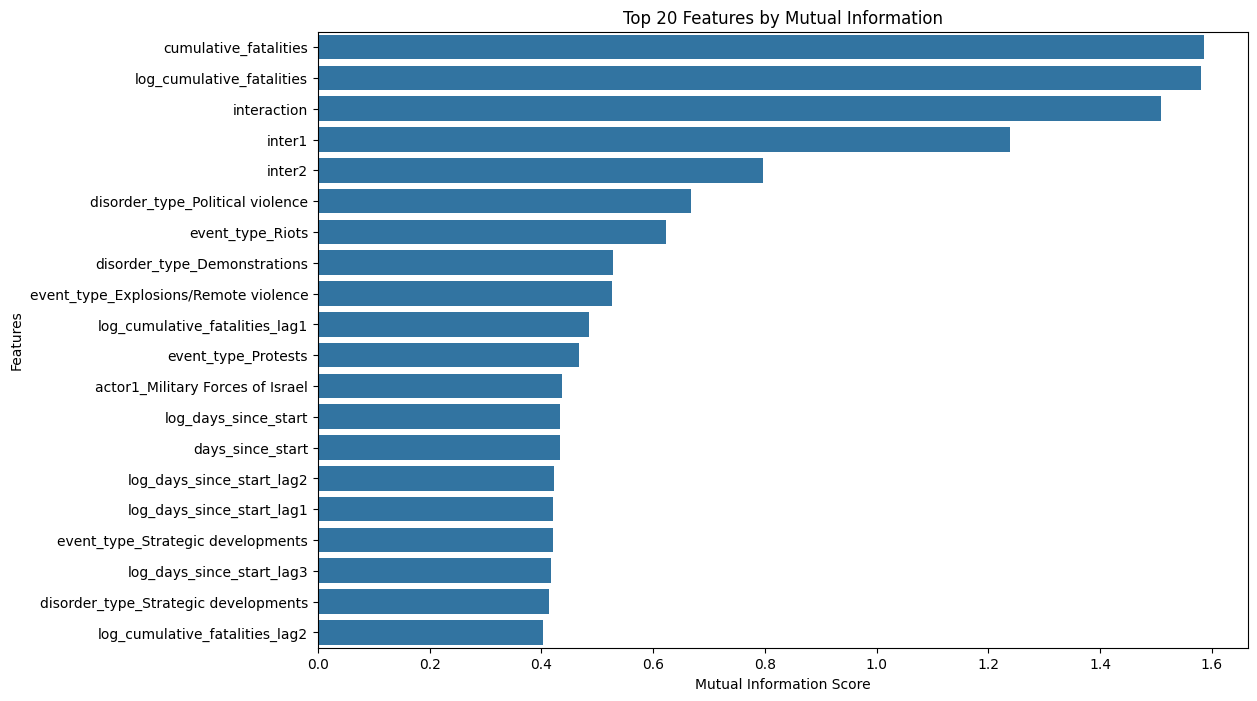

In [28]:
#Mututal Information features

target = 'sub_event_type'

# taking out the text + datetime
features = log_data_encoded.drop(columns=[target, 'event_date', 'source', 'notes'])

# actual mi score calculation
mi_scores = mutual_info_classif(features, log_data_encoded[target], discrete_features='auto')

# putting in df
mi_df = pd.DataFrame({'Feature': features.columns, 'MI_Score': mi_scores})
mi_df.sort_values('MI_Score', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='MI_Score', y='Feature', data=mi_df.sort_values('MI_Score', ascending=False).head(20))
plt.title('Top 20 Features by Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

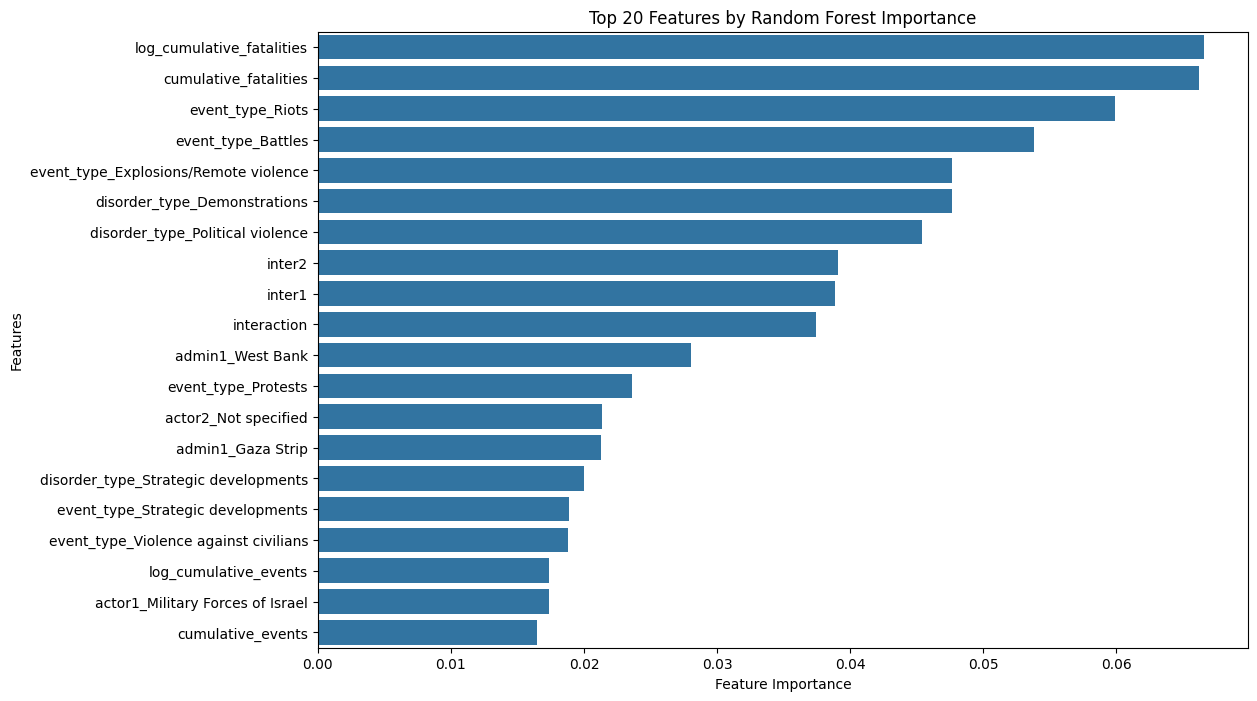

In [29]:
#Random Forest Importance
#numeric_encoded_log_data
#Dropping numeric + T/T Splitting
X = log_data_encoded.drop(['sub_event_type',  'event_date', 'source', 'notes'], axis=1)
y = log_data_encoded['sub_event_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

# feature importances into df
importances = forest.feature_importances_

rf_df = pd.DataFrame({'Feature': X_train.columns, 'RF_Importance': importances})
rf_df.sort_values('RF_Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='RF_Importance', y='Feature', data=rf_df.sort_values('RF_Importance', ascending=False).head(20))
plt.title('Top 20 Features by Random Forest Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

In [30]:
print(mi_df.shape)
print(rf_df.shape)

(151, 2)
(151, 2)


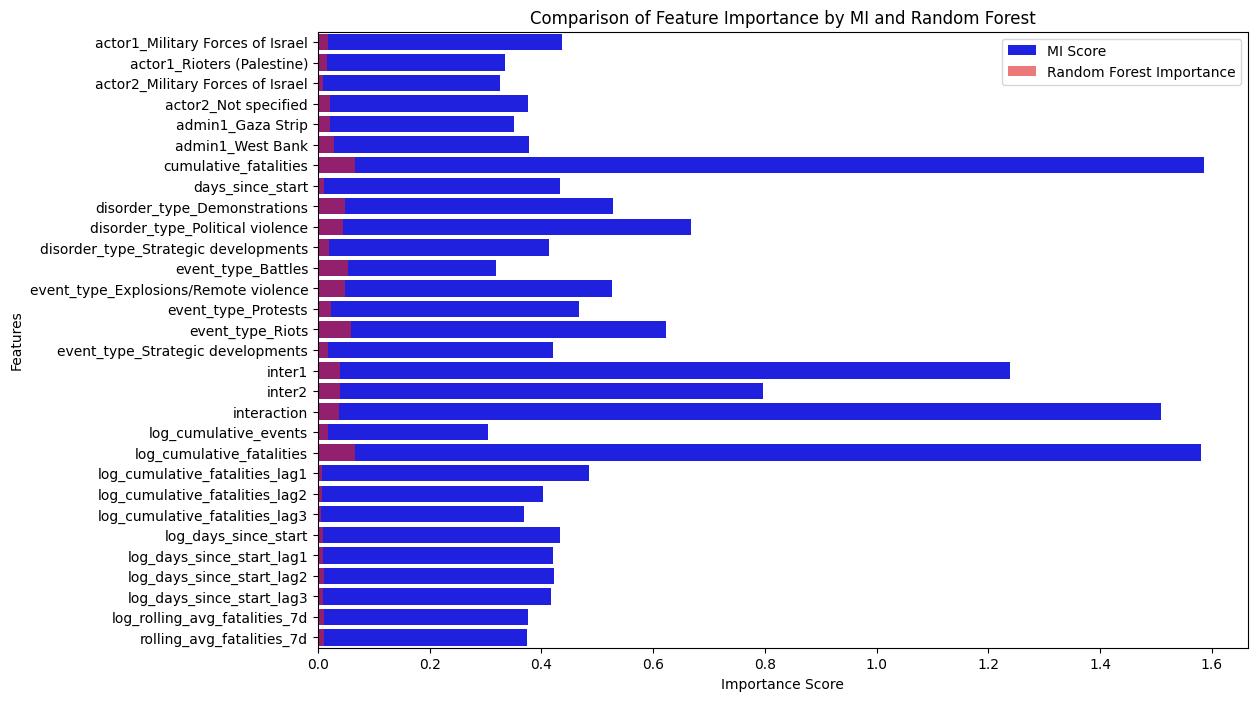

In [31]:
rf_df = pd.DataFrame({'Feature': X_train.columns,
                                    'RF_Importance': forest.feature_importances_})

#merging datasets
combined_importances = pd.merge(mi_df, rf_df, on='Feature', how='outer')

combined_importances.sort_values(by='MI_Score', ascending=False, inplace=True)

combined_importances = pd.merge(mi_df, rf_df, on='Feature', how='outer')

#set the amount of feaatures
sorted_idx = combined_importances.sort_values(by='MI_Score', ascending=False)['Feature'].head(30)


plt.figure(figsize=(12, 8))
sns.barplot(x='MI_Score', y='Feature', data=combined_importances[combined_importances['Feature'].isin(sorted_idx)], 
            color='blue', label='MI Score')
sns.barplot(x='RF_Importance', y='Feature', data=combined_importances[combined_importances['Feature'].isin(sorted_idx)], 
            color='red', alpha=0.6, label='Random Forest Importance')
plt.title('Comparison of Feature Importance by MI and Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.legend()
plt.show()


In [32]:
#setting arbitrary threshold to see the "small" values
test_thresh1 = 0.2
test_thresh2 = 0.01

#mi scores
low_mi_features = mi_df[mi_df['MI_Score'] <= test_thresh1]

#rf importances
low_rf_features = rf_df[rf_df['RF_Importance'] <= test_thresh2]

# intersection of low importance features from both
test_features = pd.merge(low_mi_features, low_rf_features, on='Feature', how='inner')

print(test_features)


                                Feature  MI_Score  RF_Importance
0                        country_Israel  0.195811   9.316109e-03
1                     country_Palestine  0.195408   6.754336e-03
2            log_cumulative_events_lag3  0.182048   7.264845e-03
3            log_cumulative_events_lag2  0.174031   7.357423e-03
4    log_rolling_avg_fatalities_7d_lag1  0.157960   5.140471e-03
..                                  ...       ...            ...
110               actor2_Other (Israel)  0.000000   9.487137e-06
111                admin1_Not specified  0.000000   1.363888e-10
112            actor2_Other (Palestine)  0.000000   2.904046e-05
113                  actor2_Other Group  0.000000   4.213719e-05
114               day_of_week_Wednesday  0.000000   8.517988e-04

[115 rows x 3 columns]


In [33]:
# MI score
mi_percentile = 70  # aka keeping top 50%
mi_threshold = np.percentile(mi_df['MI_Score'], mi_percentile)
#top_mi_features = mi_df[mi_df['MI_Score'] >= mi_threshold]
selected_mi_features = mi_df[mi_df['MI_Score'] >= mi_threshold]['Feature'].tolist()
#top_mi_features.shape
#print(selected_mi_features)

# random forest importance
rf_percentile = 70  # aka keeping top 50% | top 30% is 43 features
rf_threshold = np.percentile(rf_df['RF_Importance'], rf_percentile)
#top_rf_features = rf_df[rf_df['RF_Importance'] >= rf_threshold]
selected_rf_features = rf_df[rf_df['RF_Importance'] >= 
                                      rf_threshold]['Feature'].tolist()
#top_rf_features.shape
#print(selected_rf_features)

#Combining into 1
selected_features = list(set(selected_mi_features) & set(selected_rf_features))


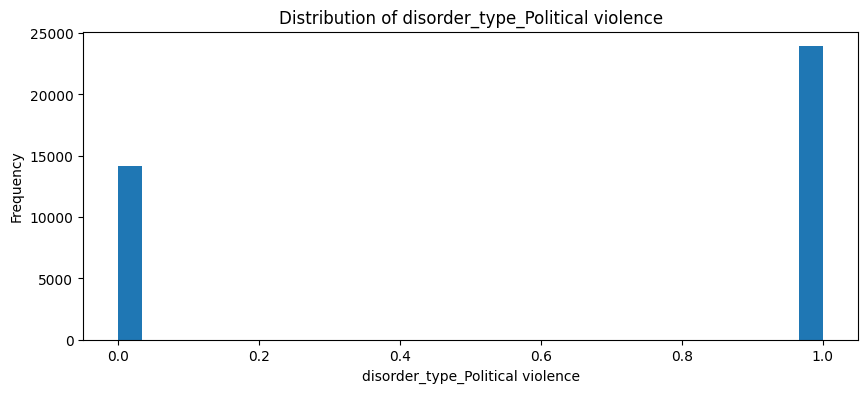

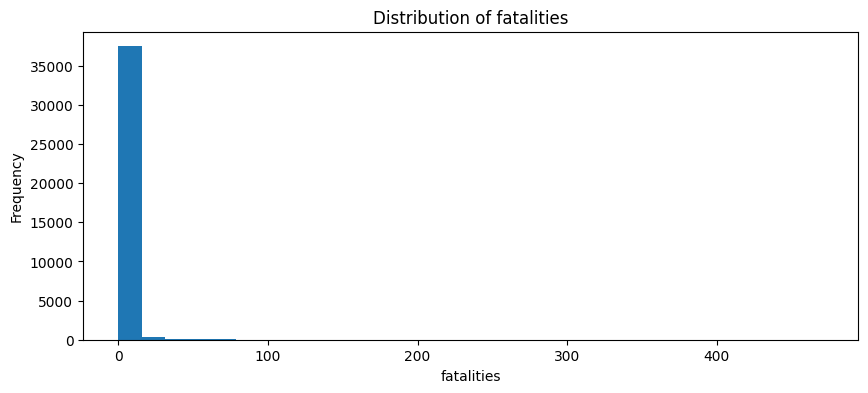

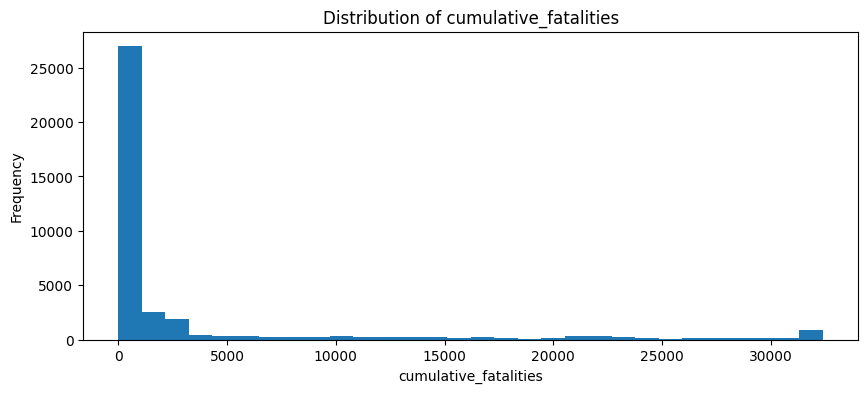

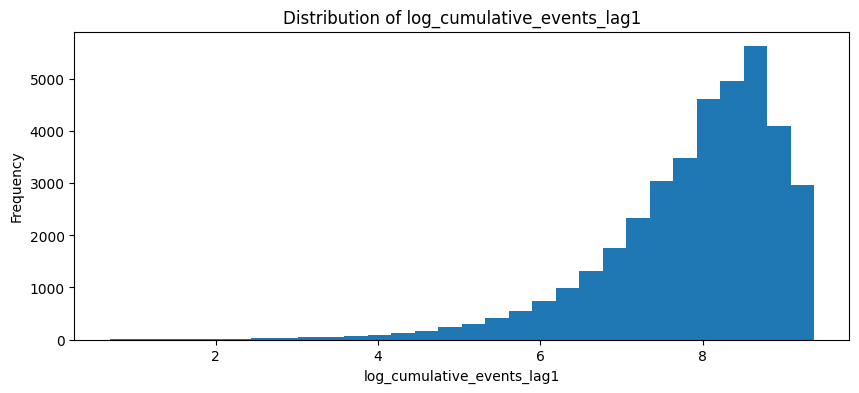

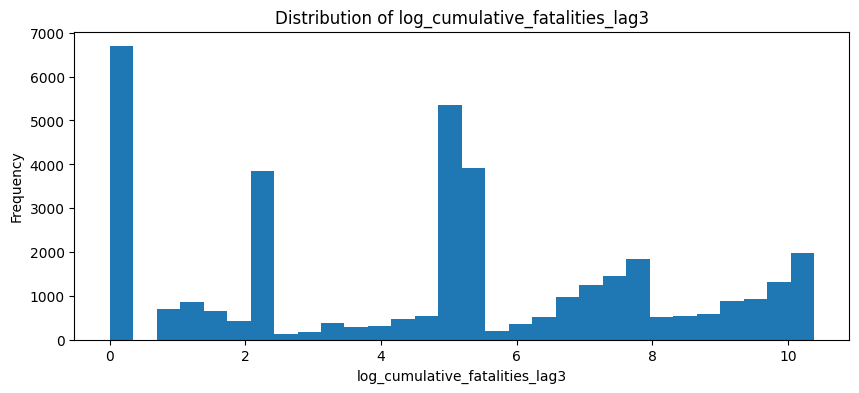

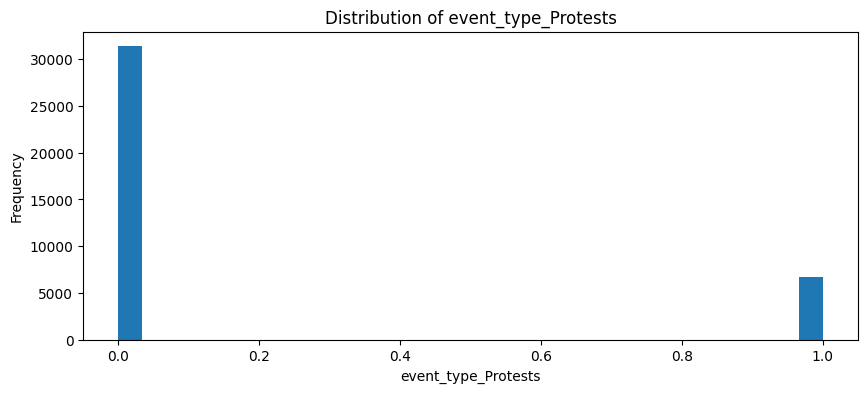

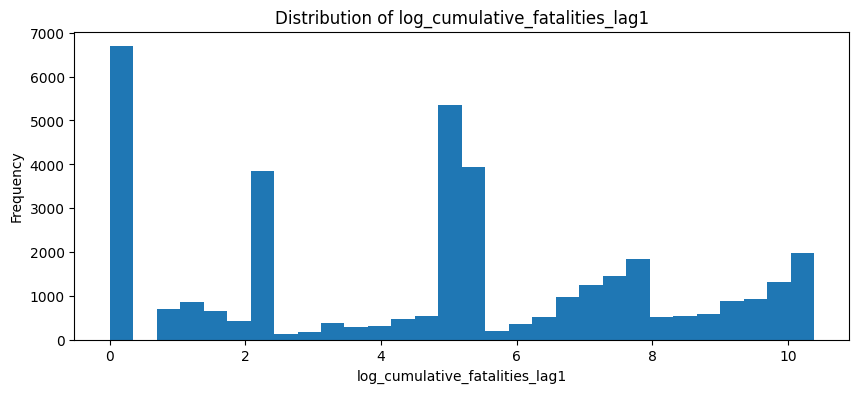

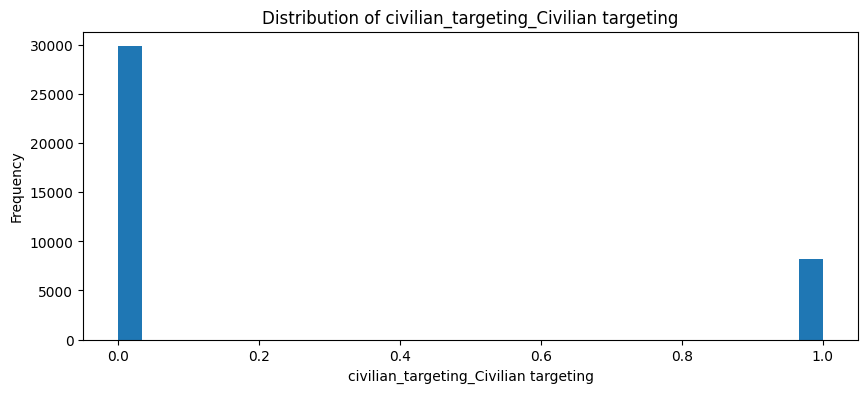

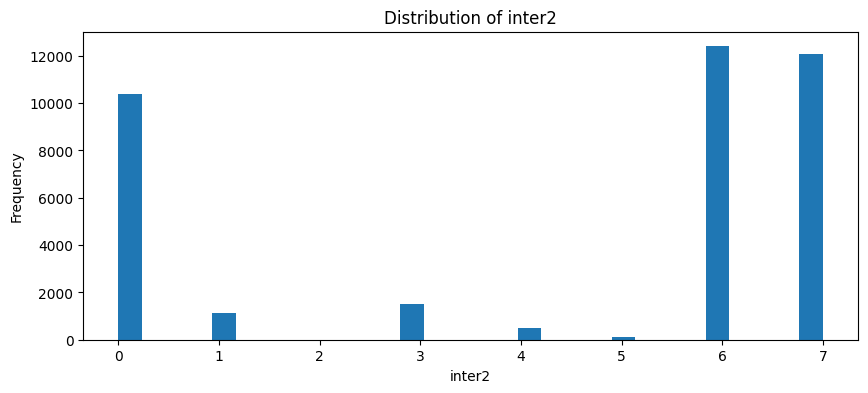

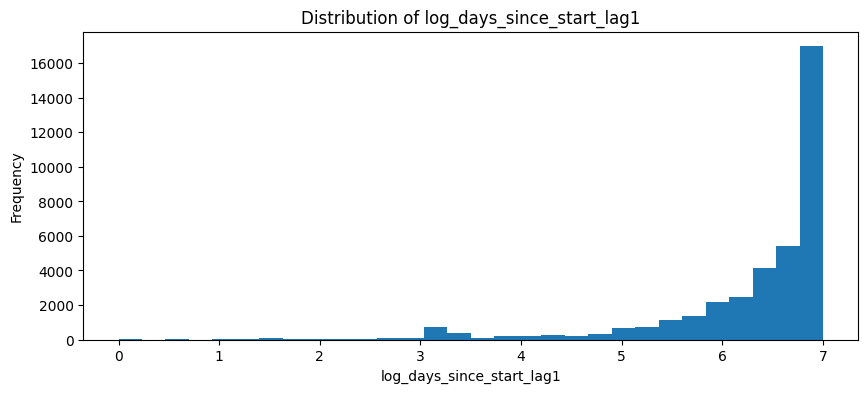

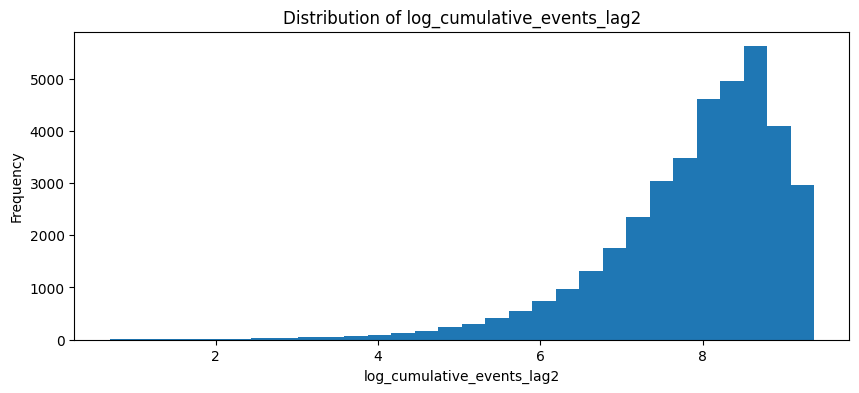

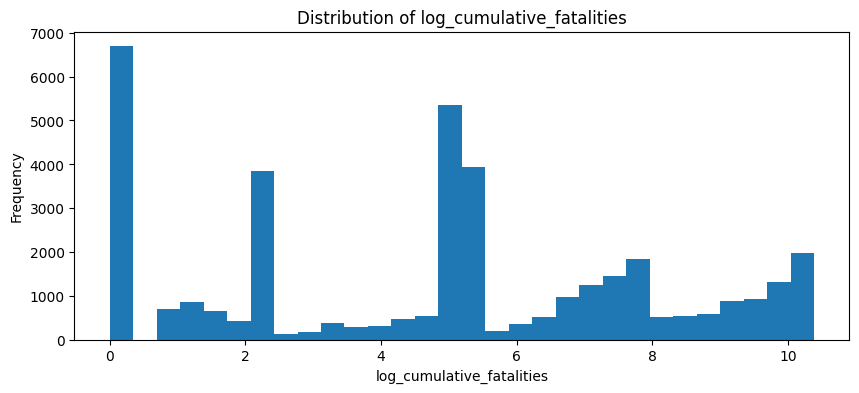

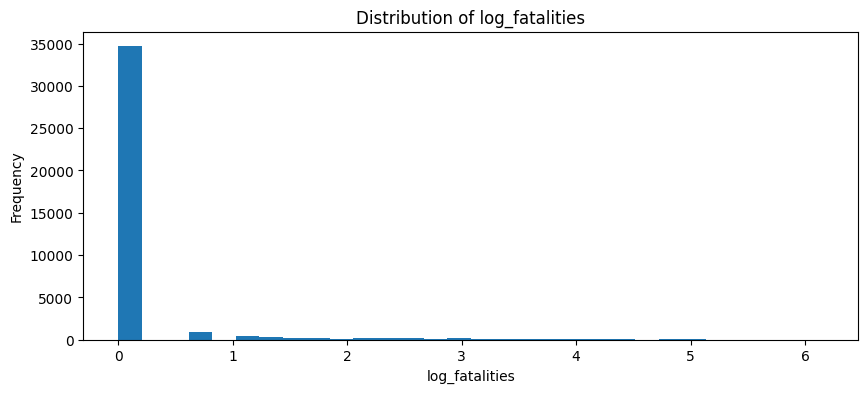

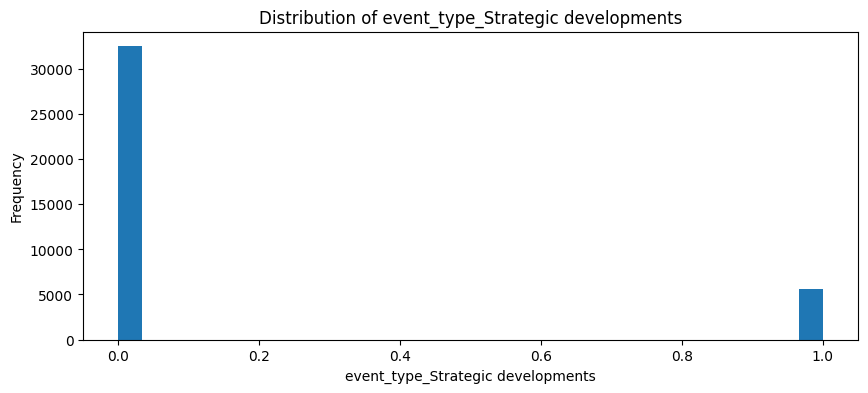

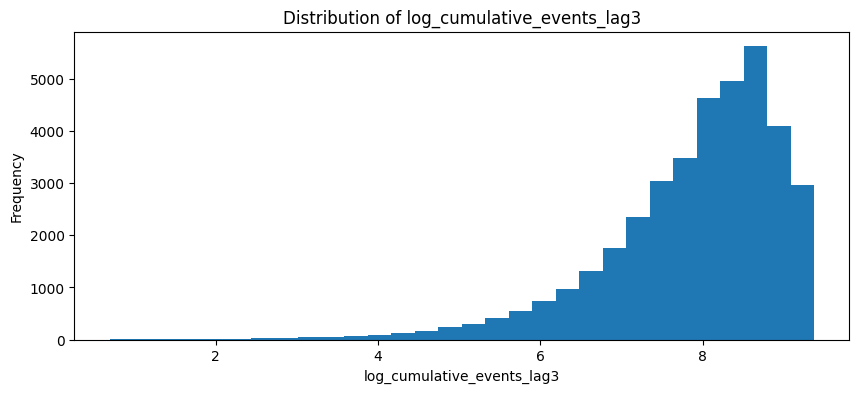

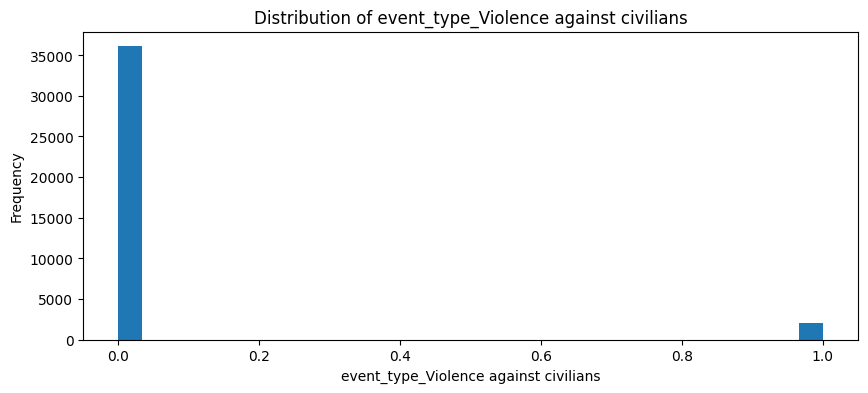

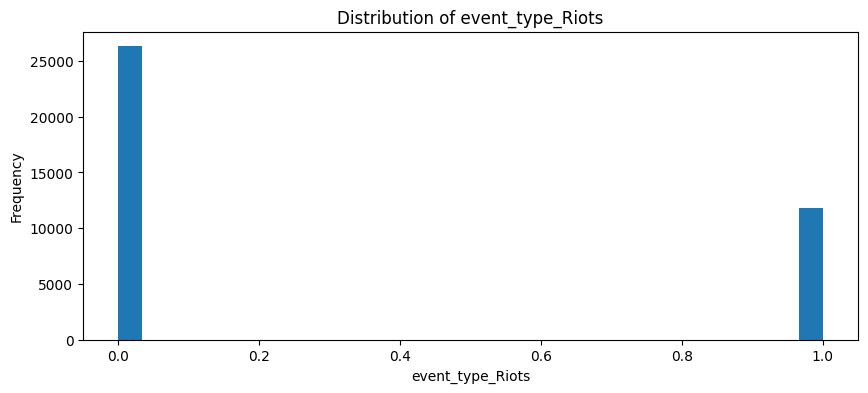

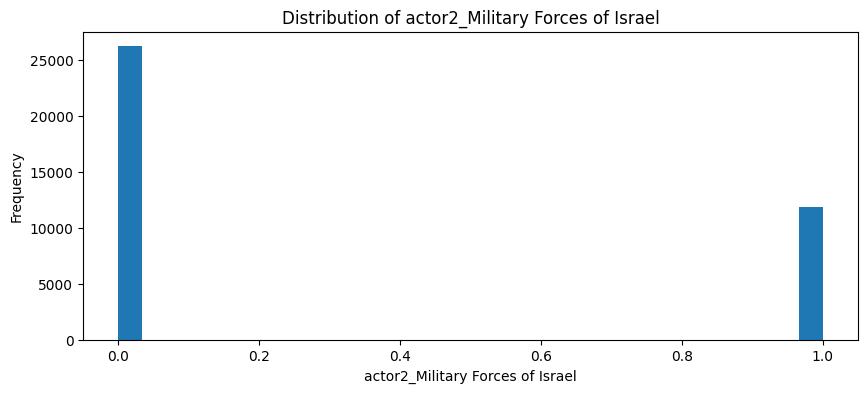

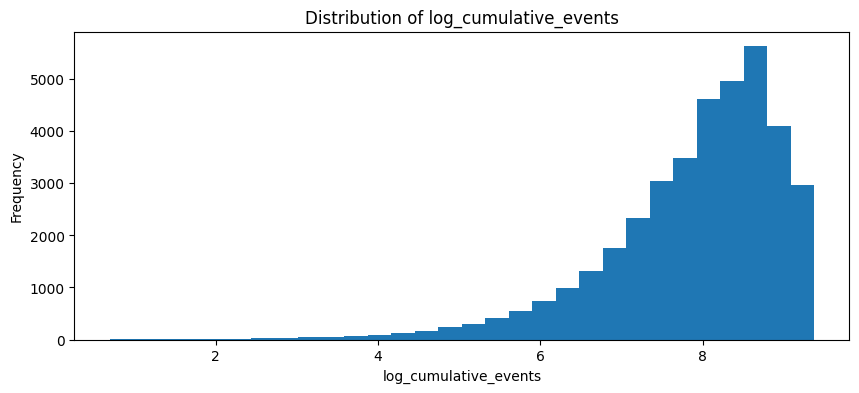

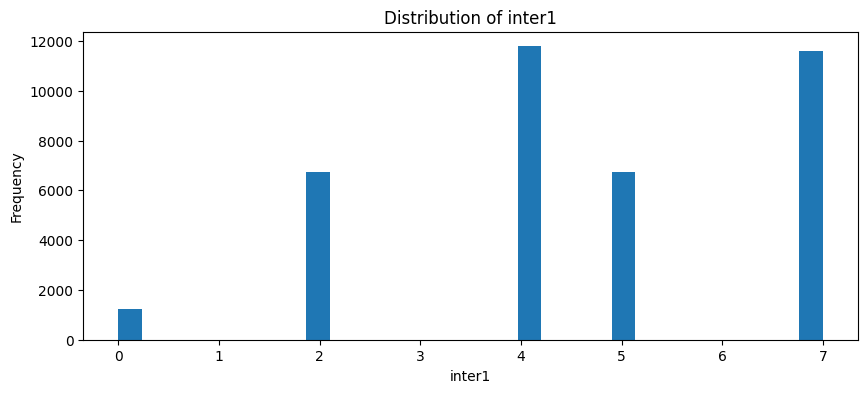

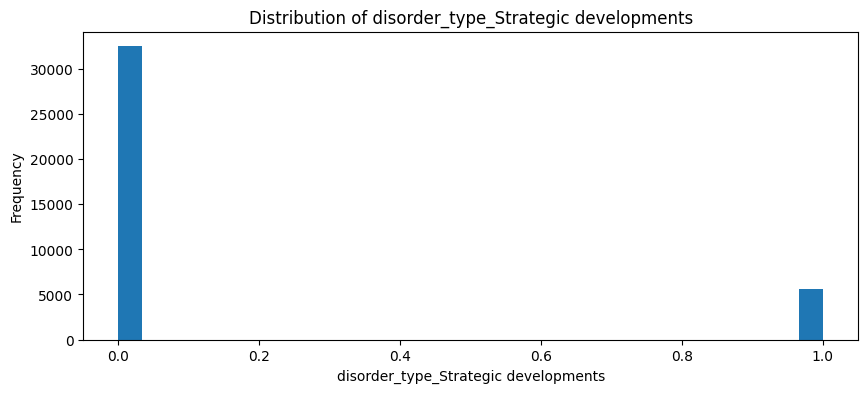

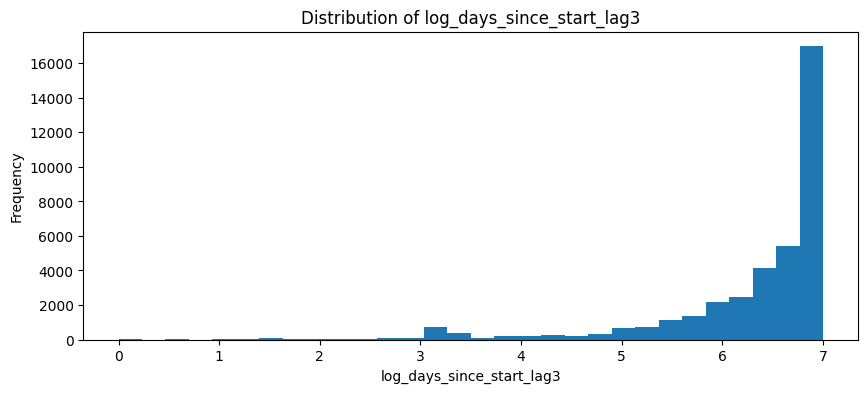

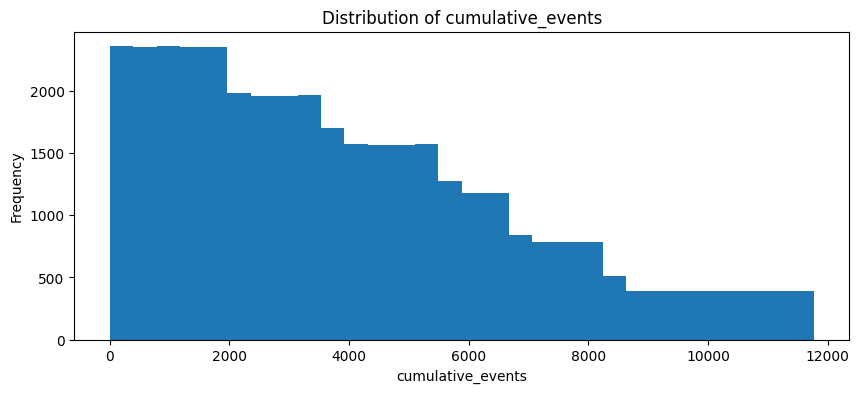

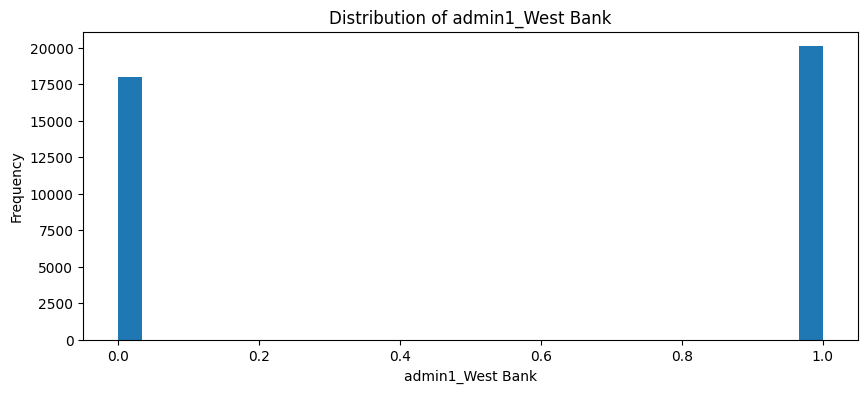

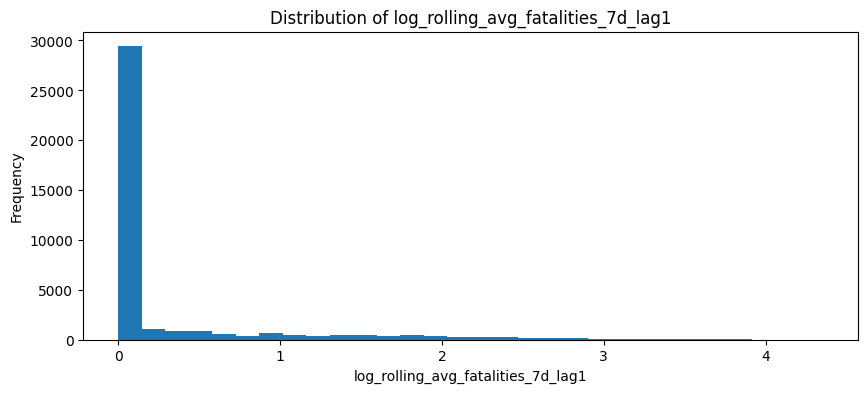

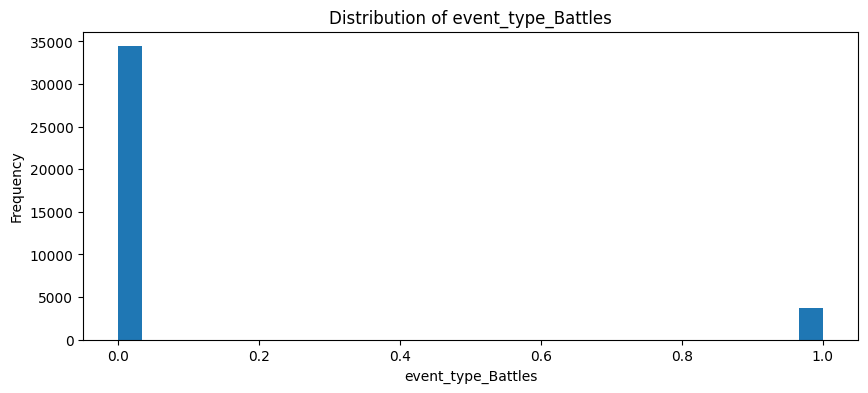

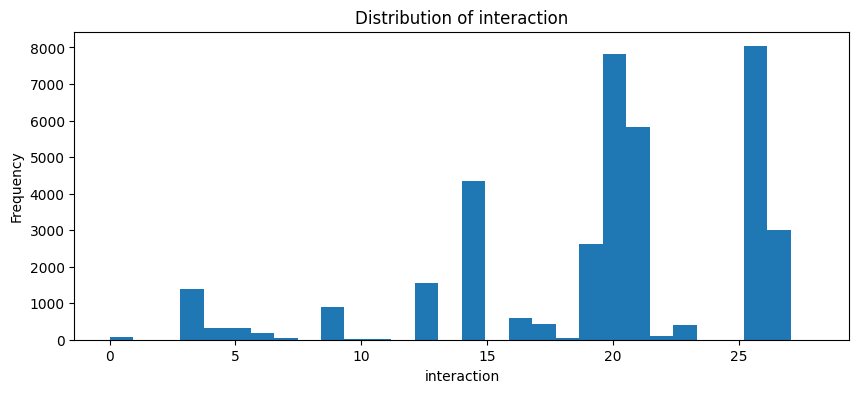

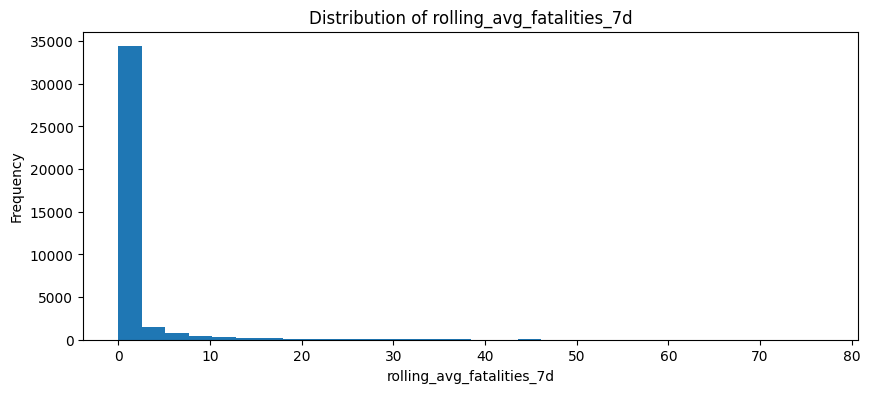

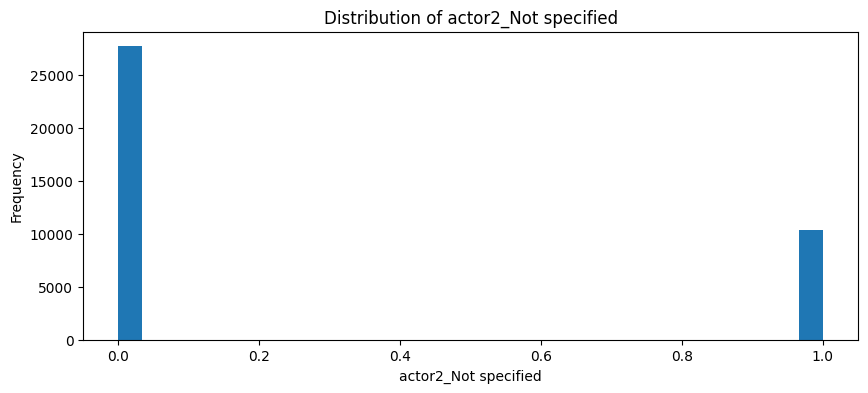

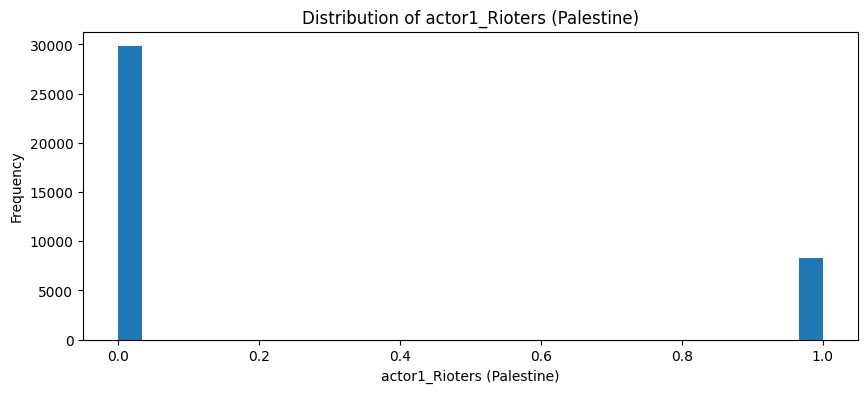

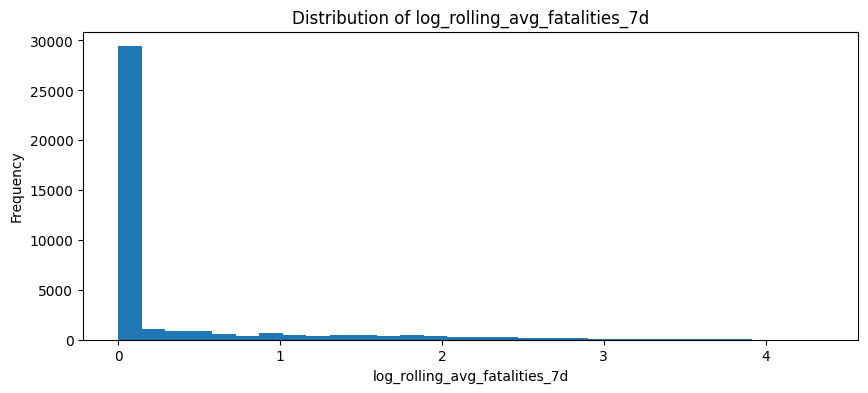

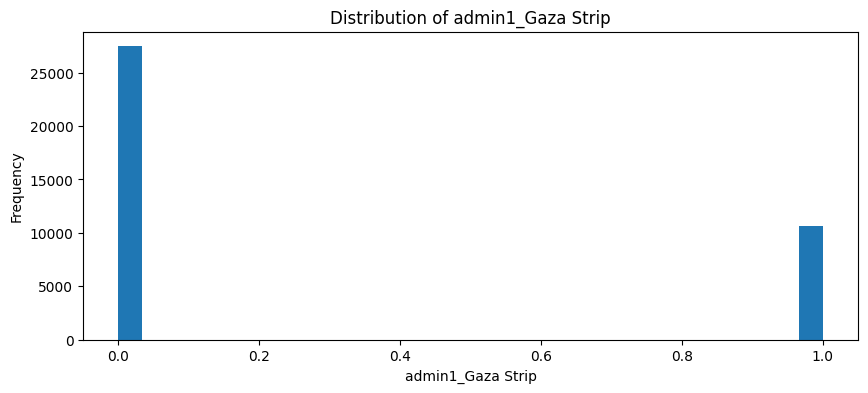

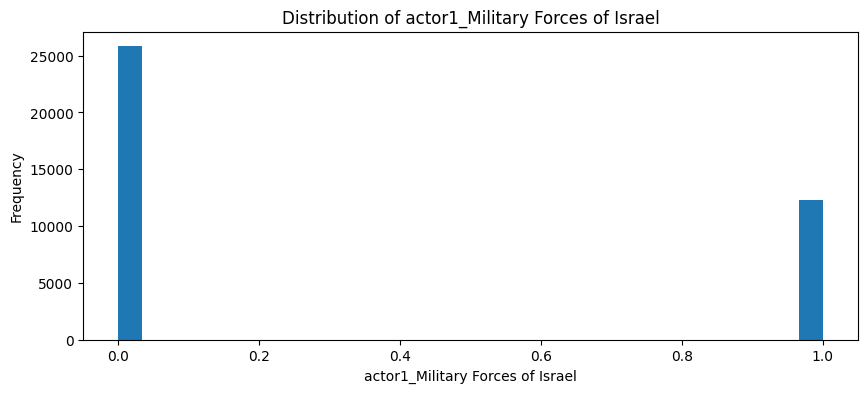

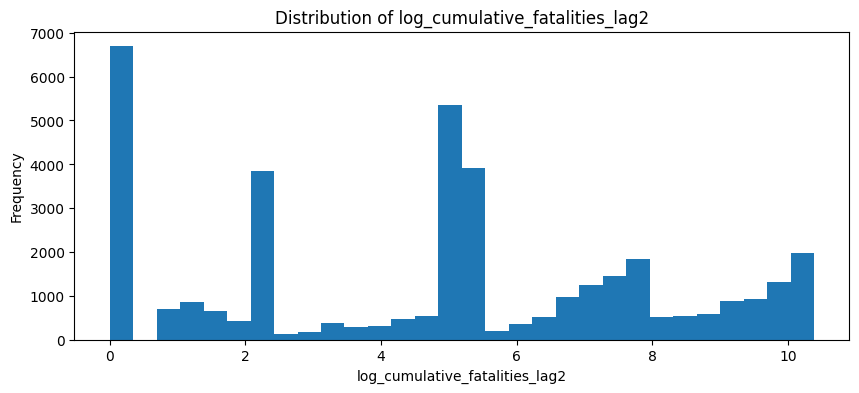

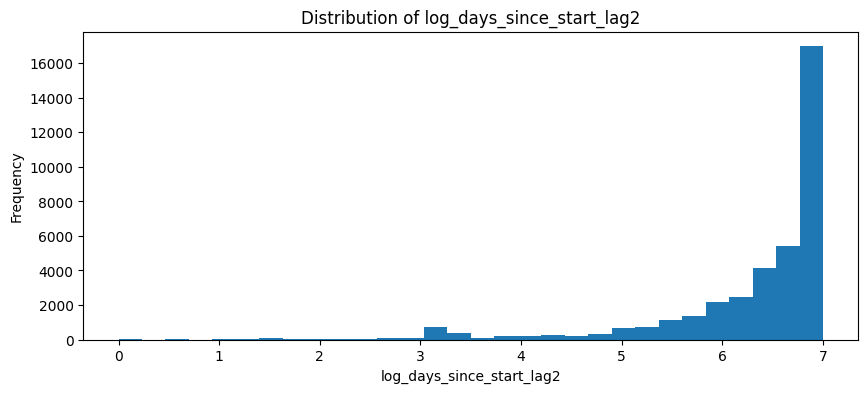

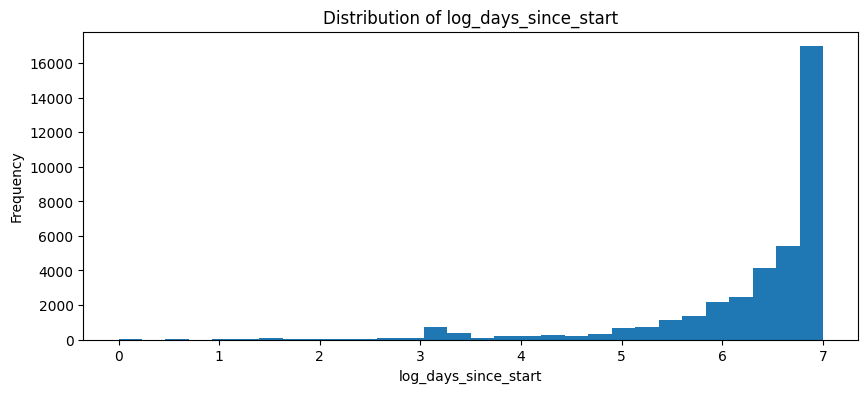

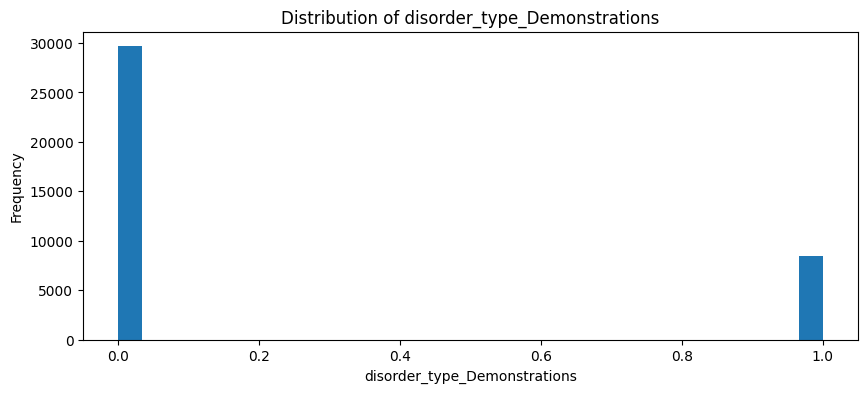

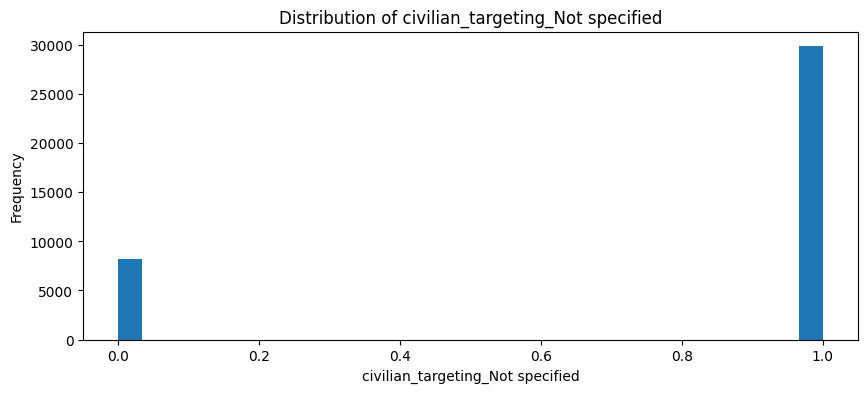

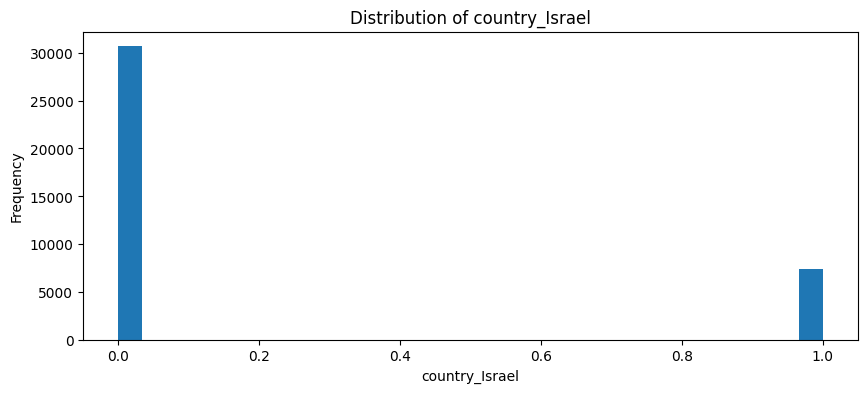

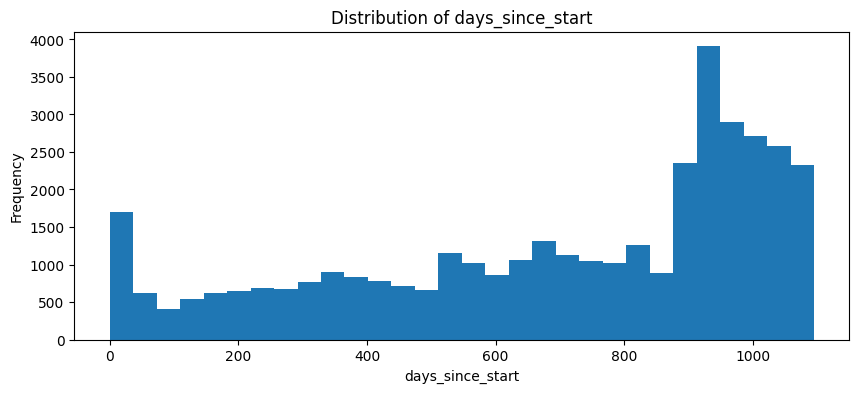

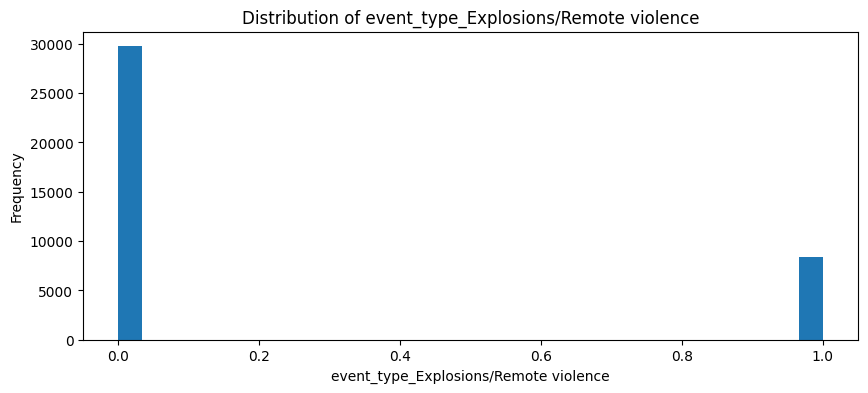

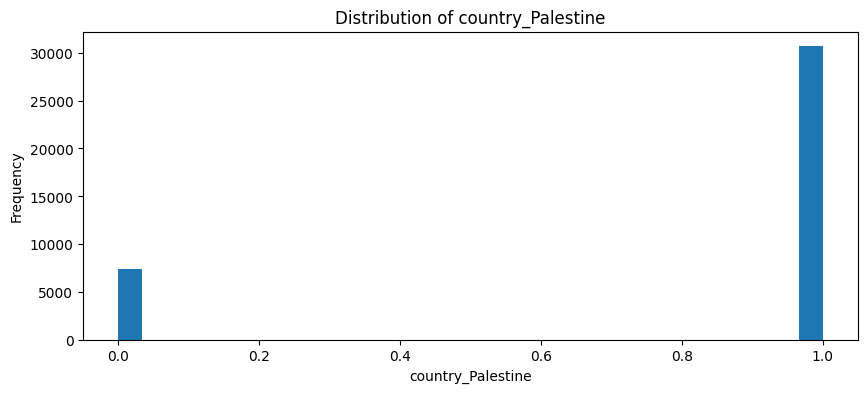

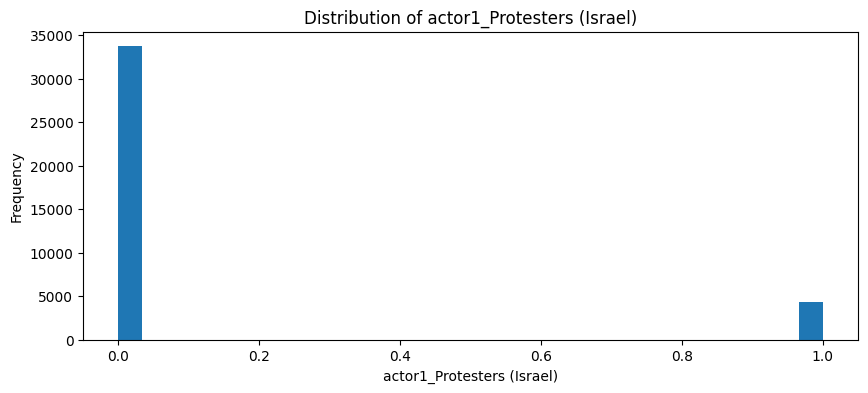

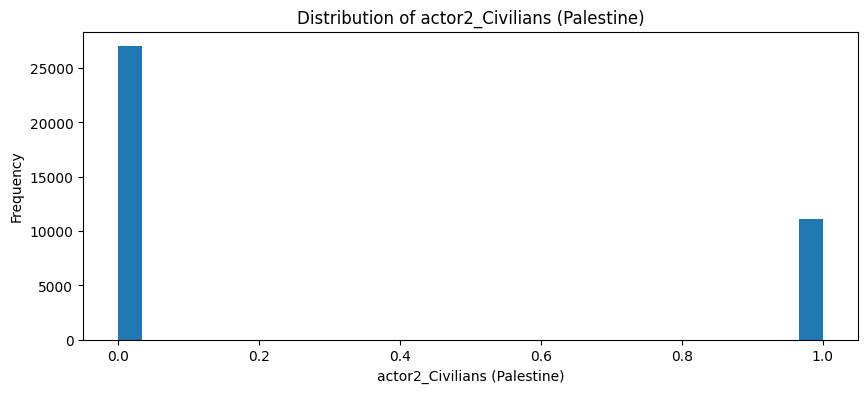

In [34]:
numeric_selected_features = [f for f in selected_features if pd.api.types.is_numeric_dtype(log_data_encoded[f])]
log_data_encoded = log_data_encoded.apply(lambda col: col.astype(int) if pd.api.types.is_bool_dtype(col) else col)

for feature in numeric_selected_features:
    plt.figure(figsize=(10, 4))
    plt.hist(log_data_encoded[feature], bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [35]:
#top_features_combined = pd.merge(top_mi_features, top_rf_features, on='Feature', how='inner')
#print(top_features_combined)
#top_features_combined.to_csv('data/top_features_combined.csv', index=False)

In [36]:
selected_features

['disorder_type_Political violence',
 'fatalities',
 'cumulative_fatalities',
 'log_cumulative_events_lag1',
 'log_cumulative_fatalities_lag3',
 'event_type_Protests',
 'log_cumulative_fatalities_lag1',
 'civilian_targeting_Civilian targeting',
 'inter2',
 'log_days_since_start_lag1',
 'log_cumulative_events_lag2',
 'log_cumulative_fatalities',
 'log_fatalities',
 'event_type_Strategic developments',
 'log_cumulative_events_lag3',
 'event_type_Violence against civilians',
 'event_type_Riots',
 'actor2_Military Forces of Israel',
 'log_cumulative_events',
 'inter1',
 'disorder_type_Strategic developments',
 'log_days_since_start_lag3',
 'cumulative_events',
 'admin1_West Bank',
 'log_rolling_avg_fatalities_7d_lag1',
 'event_type_Battles',
 'interaction',
 'rolling_avg_fatalities_7d',
 'actor2_Not specified',
 'actor1_Rioters (Palestine)',
 'log_rolling_avg_fatalities_7d',
 'admin1_Gaza Strip',
 'actor1_Military Forces of Israel',
 'log_cumulative_fatalities_lag2',
 'log_days_since_start

In [37]:
#Selected Features
X_selected = log_data_encoded[selected_features]
y = log_data_encoded['sub_event_type']

X_selected_train, X_selected_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42
                                                                      , shuffle=False)

#REgular model minus text
X = log_data_encoded.drop(['sub_event_type', 'event_date', 'source', 'notes'], axis=1) # 'event_date', 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [38]:
y_test

30505    12
30506    12
30507     2
30508    18
30509    14
         ..
38125    14
38126    12
38127    15
38128    12
38129    11
Name: sub_event_type, Length: 7618, dtype: int32

In [39]:
def naive_forecast_last(train_data):
    return train_data.iloc[-1]

last_value = naive_forecast_last(y_train)  # Get the last value from the training target
predictions = [last_value] * len(y_test)  # Create a list of predictions for the test set

# Evaluate the prediction
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of Naïve Forecast: {accuracy:.2f}")

Accuracy of Naïve Forecast: 0.02


In [40]:
def naive_forecast_last(train_data):
    return train_data.iloc[-1]

last_value = naive_forecast_last(y_train)  # Get the last value from the training target
predictions = [last_value] * len(y_test)  # Create a list of predictions for the test set

# Evaluate the prediction
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of Naïve Forecast: {accuracy:.2f}")


Accuracy of Naïve Forecast: 0.02


In [41]:
#Decision Tree Selected 

tree_classifier = DecisionTreeClassifier(random_state=42)

tree_classifier.fit(X_selected_train, y_train)

tree_predictions = tree_classifier.predict(X_selected_test)

tree_accuracy = accuracy_score(y_test, tree_predictions)
tree_classification_report = classification_report(y_test, tree_predictions)
print(f"Accuracy of Decision Tree Selected: {tree_accuracy:.2f}")
print(tree_classification_report)

Accuracy of Decision Tree Selected: 0.93
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.66      0.18      0.28       152
           3       1.00      1.00      1.00       161
           4       0.10      0.07      0.08        14
           5       1.00      1.00      1.00       440
           6       0.84      0.88      0.85        64
           7       0.80      0.82      0.81        44
           8       1.00      1.00      1.00       108
          10       0.14      0.50      0.22         2
          11       0.92      0.46      0.61       564
          12       1.00      1.00      1.00      2720
          14       0.70      0.97      0.81       752
          15       1.00      1.00      1.00      1519
          16       1.00      0.99      1.00       281
          17       0.00      0.00      0.00         7
          18       0.51      0.84      0.63       163
          19       1.00      1.00      1

In [42]:
#Decision Tree Baseline
tree_classifier = DecisionTreeClassifier(random_state=42)

tree_classifier.fit(X_train, y_train)

tree_predictions = tree_classifier.predict(X_test)

tree_accuracy = accuracy_score(y_test, tree_predictions)
tree_classification_report = classification_report(y_test, tree_predictions)
print(f"Accuracy of Decision Tree Selected: {tree_accuracy:.2f}")
print(tree_classification_report)


Accuracy of Decision Tree Selected: 0.95
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.79      0.77      0.78       152
           3       1.00      1.00      1.00       161
           4       0.20      0.14      0.17        14
           5       1.00      1.00      1.00       440
           6       0.85      0.83      0.84        64
           7       0.74      0.45      0.56        44
           8       0.97      1.00      0.99       108
          10       0.14      0.50      0.22         2
          11       0.88      0.63      0.73       564
          12       1.00      1.00      1.00      2720
          14       0.77      0.96      0.86       752
          15       1.00      1.00      1.00      1519
          16       1.00      0.99      1.00       281
          17       0.11      0.14      0.12         7
          18       0.77      0.75      0.76       163
          19       1.00      1.00      1

D:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
# Logistic Regression Selected

logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)

logistic_regressor.fit(X_train, y_train)

logistic_predictions = logistic_regressor.predict(X_test)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_classification_report = classification_report(y_test, logistic_predictions)

print(f"Accuracy of Logistic Regression Baseline: {logistic_accuracy:.2f}")
print(logistic_classification_report)

Accuracy of Logistic Regression Baseline: 0.43
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.44      0.03      0.05       152
           3       1.00      0.24      0.38       161
           4       0.00      0.00      0.00        14
           5       0.79      1.00      0.89       440
           6       0.00      0.00      0.00        64
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00       108
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00       564
          12       0.88      0.57      0.69      2720
          14       0.27      1.00      0.42       752
          15       0.92      0.32      0.47      1519
          16       0.00      0.00      0.00       281
          17       0.02      0.86      0.04         7
          18       0.00      0.00 

D:\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in 

In [44]:
# Logistic Regression Baseline

logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)

logistic_regressor.fit(X_selected_train, y_train)

logistic_predictions = logistic_regressor.predict(X_selected_test)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_classification_report = classification_report(y_test, logistic_predictions)

print(f"Accuracy of Logistic Regression Baseline: {logistic_accuracy:.2f}")
print(logistic_classification_report)

Accuracy of Logistic Regression Baseline: 0.65
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.50      0.03      0.05       152
           3       0.27      1.00      0.42       161
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00       440
           6       0.00      0.00      0.00        64
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00       108
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00       564
          12       0.81      1.00      0.90      2720
          14       0.41      0.93      0.57       752
          15       0.83      0.90      0.87      1519
          16       0.00      0.00      0.00       281
          17       0.02      0.86      0.04         7
          18       0.00      0.00      0.00       163
          19       0.00      0.00 

D:\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

In [45]:
numeric_log_data = log_data_encoded.drop(columns=[target,'source', 'notes'])
#def test_stationarity(series):
    #result = adfuller(series.dropna(), autolag='AIC') 
    #return {"Test Statistic": result[0], "p-value": result[1], "Critical Values": result[4]}

In [46]:
#results = {column: test_stationarity(numeric_log_data[column]) for column in numeric_log_data.columns}

#results


In [47]:
# differencing to 'year', 'month', and 'days_since_start'
#numeric_log_data['year_diff'] = numeric_log_data['year'].diff()
#numeric_log_data['month_diff'] = numeric_log_data['month'].diff()
#numeric_log_data['days_since_start_diff'] = numeric_log_data['days_since_start'].diff()

#data = data.dropna(subset=['year_diff', 'month_diff', 'days_since_start_diff'])

# testing stationarity after differencing
#new = {
#    'year_diff': test_stationarity(numeric_log_data['year_diff']),
#    'month_diff': test_stationarity(numeric_log_data['month_diff']),
#    'days_since_start_diff': test_stationarity(numeric_log_data['days_since_start_diff'])}

#new


Everything is now stationary

In [48]:
X_train.dtypes

year                     int32
inter1                   int64
inter2                   int64
interaction              int64
fatalities               int64
                         ...  
day_of_week_Saturday     int32
day_of_week_Sunday       int32
day_of_week_Thursday     int32
day_of_week_Tuesday      int32
day_of_week_Wednesday    int32
Length: 151, dtype: object

In [55]:
max_index_value = np.max(X_train)
unique_indices = len(np.unique(X_train))
print("Max index value:", max_index_value)
print("Unique indices:", unique_indices)

max_index_test = np.max(X_test)
print("Max index in X_test:", max_index_test)

Max index value: 32180.0
Unique indices: 20136
Max index in X_test: 32404.0


In [56]:
# converting to categorical
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

input_dim = 32405
#  LSTM model
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=100, input_length=X_train.shape[1])) #input_dim=len(np.unique(y))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train_encoded, epochs=2, batch_size=32, validation_split=0.1)

#eval
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/2


D:\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


857/857 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.1987 - loss: 2.3265 - val_accuracy: 0.3642 - val_loss: 2.3154
Epoch 2/2
857/857 ━━━━━━━━━━━━━━━━━━━━ 60s 70ms/step - accuracy: 0.2139 - loss: 2.2520 - val_accuracy: 0.3642 - val_loss: 2.3338
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.4239 - loss: 2.2785
Test Accuracy: 0.36


In [57]:
# predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # convert probabilities to class labels

# errors
for i in errors[:10]:  # first 20 
    print(f'Index: {i}, Predicted: {y_pred_classes[i]}, Actual: {actual_classes[i]}')

# Calculate metrics
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step


NameError: name 'errors' is not defined

In [ ]:
actual_classes = np.argmax(y_test_encoded, axis=1) if y_test_encoded.ndim > 1 else y_test
errors = np.where(y_pred_classes != actual_classes)[0]
print(f'Number of errors: {len(errors)} / {len(actual_classes)}')

In [ ]:
predicted_labels = label_encoders['sub_event_type'].inverse_transform(y_pred_classes)

actual_labels = label_encoders['sub_event_type'].inverse_transform(y_test)

for actual, predicted in zip(actual_labels[:10], predicted_labels[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")


In [ ]:
#Time-series plot?
event_dates_test = data.loc[X_test.index, 'event_date']


results_df = pd.DataFrame({
    'event_date': event_dates_test,
    'actual_labels': label_encoders['sub_event_type'].inverse_transform(y_test),
    'predicted_labels': label_encoders['sub_event_type'].inverse_transform(y_pred_classes)
})

results_df.sort_values('event_date', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(results_df['event_date'], results_df['actual_labels'], label='Actual', marker='o')
plt.plot(results_df['event_date'], results_df['predicted_labels'], label='Predicted', marker='x')
plt.title('Actual vs. Predicted Labels Over Time')
plt.xlabel('Event Date')
plt.ylabel('Labels')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
X = log_data_encoded.drop(['sub_event_type', 'event_date', 'source', 'notes'], axis=1)
y = log_data_encoded['sub_event_type'].values
label_encoder = LabelEncoder().fit(y)  # Make sure to fit on all available labels
y_encoded = to_categorical(label_encoder.transform(y))

#model
def create_model(input_length, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=num_classes, output_dim=100, input_length=input_length))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores, cv_precision, cv_recall, cv_f1 = [], [], [], []

In [ ]:
for fold, (train, test) in enumerate(kfold.split(X, y_encoded), 1):
#make model
    model = create_model(X.shape[1], y_encoded.shape[1])
    model.fit(X.iloc[train], y_encoded[train], epochs=10, batch_size=32, verbose=0)
    
#eval
    scores = model.evaluate(X.iloc[test], y_encoded[test], verbose=0)
    cv_scores.append(scores[1])
    
# predicts + transform into og labels
    y_pred = model.predict(X.iloc[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    y_actual_labels = label_encoder.inverse_transform(np.argmax(y_encoded[test], axis=1))
    
# metrics
    precision = precision_score(y_actual_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_actual_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_actual_labels, y_pred_labels, average='weighted')
    cv_precision.append(precision)
    cv_recall.append(recall)
    cv_f1.append(f1)

# Confusion matrix
    conf_matrix = confusion_matrix(y_actual_labels, y_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
print(f'Mean Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}')
print(f'Mean Precision: {np.mean(cv_precision):.2f}')
print(f'Mean Recall: {np.mean(cv_recall):.2f}')
print(f'Mean F1-Score: {np.mean(cv_f1):.2f}')